In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings                
warnings.filterwarnings('ignore')

In [2]:
years = [2017,2018,2019,2020,2021,2022,2023]

In [3]:
files=['sqf-2017.xlsx',
 'sqf-2018.xlsx',
 'sqf-2019.xlsx',
 'sqf-2020.xlsx',
 'sqf-2021.xlsx',
 'sqf-2022.xlsx',
 'sqf-2023.xlsx',
 ]

df = pd.read_excel('./sqf-2024.xlsx')
for file,year in zip(files,years):
    df_year = pd.read_excel(file)
    df_year['year'] = year
    cols = [col for col in df.columns if col in df_year.columns]
    print(f"{year} : {df_year.shape}")
    df = pd.concat([df,df_year[cols]])


2017 : (11629, 84)
2018 : (11008, 84)
2019 : (13459, 84)
2020 : (9544, 84)
2021 : (8947, 84)
2022 : (15102, 83)
2023 : (16971, 83)


In [4]:
df.shape

(112046, 81)

In [5]:
df.head()

,STOP_ID,STOP_FRISK_DATE,STOP_FRISK_TIME,YEAR2,MONTH2,DAY2,STOP_WAS_INITIATED,ISSUING_OFFICER_RANK,ISSUING_OFFICER_COMMAND_CODE,SUPERVISING_OFFICER_RANK,...,SUSPECT_OTHER_DESCRIPTION,STOP_LOCATION_PRECINCT,STOP_LOCATION_SECTOR_CODE,STOP_LOCATION_APARTMENT,STOP_LOCATION_FULL_ADDRESS,STOP_LOCATION_STREET_NAME,STOP_LOCATION_X,STOP_LOCATION_Y,STOP_LOCATION_PATROL_BORO_NAME,STOP_LOCATION_BORO_NAME
0,279772561.0,2024-01-01,01:58:00,2024,January,Monday,Based on Self Initiated,PO,46,SGT,...,(null),046,A,(null),1775 CLAY AVE,CLAY AVE,1010576,247603,PBBX,BRONX
1,279772564.0,2024-01-01,00:48:00,2024,January,Monday,Based on Self Initiated,PO,120,SGT,...,BLACK HOODIE SWEATSHIRT,067,D,(null),4515 FARRAGUT RD,FARRAGUT RD,1002798,171482,PBBS,BROOKLYN
2,279772565.0,2024-01-01,01:10:00,2024,January,Monday,Based on Radio Run,PO,871,SGT,...,SCAR ON LIP,068,D,(null),&&,NaN,977764,170616,PBBS,BROOKLYN
3,279772566.0,2024-01-01,01:10:00,2024,January,Monday,Based on Radio Run,PO,871,SGT,...,RED JACKET/ RED HAT,068,D,(null),&&,NaN,977764,170616,PBBS,BROOKLYN
4,279772567.0,2024-01-01,01:10:00,2024,January,Monday,Based on Radio Run,PO,871,SGT,...,BLACK JACKET,068,D,(null),&&,NaN,977764,170616,PBBS,BROOKLYN


In [6]:
target = 'FRISKED_FLAG'

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.feature_selection import RFE
from sklearn import metrics
import xgboost as xgb

def confunsion_matrix(y_test,y_pred):
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

def get_model_performance(y_test,y_pred):
    # print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    # print("Precision:",metrics.precision_score(y_test, y_pred,average="binary", pos_label="Y"))
    # print("Recall:",metrics.recall_score(y_test, y_pred,average="binary", pos_label="Y"))
    # print("F1:",metrics.f1_score(y_test, y_pred,average="binary", pos_label="Y"))

    acc_score = metrics.accuracy_score(y_test,y_pred)
    precision = metrics.precision_score(y_test, y_pred,average="binary", pos_label="Y")
    recall = metrics.recall_score(y_test, y_pred,average="binary", pos_label="Y")
    f1 = metrics.f1_score(y_test, y_pred,average="binary", pos_label="Y")

    return acc_score,precision,recall,f1
def acu_plot(clf,X_test,y_test):
    y_pred_proba = clf.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba, pos_label="Y")
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot(fpr,tpr,label="auc="+str(auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)
    plt.show()

def model_performance(clf,X_test,y_test,y_pred):
    confunsion_matrix(y_test,y_pred)
    acu_plot(clf,X_test,y_test)
    acc,precision,recall,f1=get_model_performance(y_test, y_pred)
    return acc,precision,recall,f1

def run_year_level_model(data,year,target):
    data = data[data['YEAR2']==year].copy()
    print(data[target].value_counts())
    x = data.drop(columns=[target])
    y = data[target]
    print(y.value_counts())
    lab_enc = preprocessing.LabelEncoder(); y_encoded = lab_enc.fit_transform(y) # this removes an encoding error 


    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,stratify=y, random_state=23)

    
    y_train_num = np.where(y_train=='Y',1,0)
    #y_test_num = np.where(y_test=='Y',1,0) 
    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',  
        random_state=42
    ).fit(X_train, y_train_num)
    
    y_pred_num = xgb_model.predict(X_test)
    y_pred = np.where(y_pred_num==1,'Y','N')
    acc,precision,recall,f1=model_performance(xgb_model,X_test,y_test, y_pred)
    
    
    feature_important = model.get_booster().get_score(importance_type='weight')
    keys = list(feature_important.keys())
    values = list(feature_important.values())
    
    imp_df = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

    return imp_df

In [8]:
from sklearn.preprocessing import LabelEncoder

def prepare_data(df,year, target_column):
    """
    Automatically handles data types by converting categorical columns to numerical.
    Splits data into train and test sets.
    
    Args:
        df (pd.DataFrame): Input dataset.
        target_column (str): Name of the target variable.

    Returns:
        X_train, X_test, y_train, y_test: Processed datasets for training and testing.
    """
    df = df[df['YEAR2']==year].copy()
    
    # Handle categorical features
    for col in df.select_dtypes(include=['object', 'category']).columns:
        df[col] = df[col].astype(str)
        df[col] = LabelEncoder().fit_transform(df[col])
    
    # Handle missing values (fill with median for numeric columns)
    df.fillna(df.median(numeric_only=True), inplace=True)

    # Split into features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Convert target to numeric if it's categorical
    if y.dtype == 'object' or y.dtype.name == 'category':
        y = LabelEncoder().fit_transform(y)

    # Split data into train and test sets
    return train_test_split(X, y, test_size=0.2, stratify=y,random_state=42)

def train_xgboost(X_train, X_test, y_train, y_test):
    """
    Trains an XGBoost model and returns feature importance.

    Args:
        X_train, X_test, y_train, y_test: Processed training and testing datasets.

    Returns:
        pd.DataFrame: Feature importance sorted in descending order.
    """
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")  # Use XGBRegressor() for regression tasks
    model.fit(X_train, y_train)

    # Get feature importance
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    return feature_importance

def run_year_level_model(data,year,target):
    print(year)
    X_train, X_test, y_train, y_test = prepare_data(data,year, target)
    feature_importance_df = train_xgboost(X_train, X_test, y_train, y_test)
    feature_importance_df['year']=year
    return feature_importance_df.head(10),feature_importance_df[feature_importance_df.Feature=='SUSPECT_RACE_DESCRIPTION']
    

In [9]:
imp_feat_year_level = pd.DataFrame()
race_imp_feat = pd.DataFrame()
years = [2018,2019,2020,2021,2022,2023,2024]
for year in years:
    res1,res2 = run_year_level_model(df,year,target)
    imp_feat_year_level = pd.concat([imp_feat_year_level,res1])
    race_imp_feat = pd.concat([race_imp_feat,res2])
    

2018
2019
2020
2021
2022
2023
2024


In [31]:
imp_feat_year_level

,Feature,Importance,year
45,BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG,0.277494,2018
48,SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG,0.191952,2018
57,SEARCH_BASIS_HARD_OBJECT_FLAG,0.035036,2018
46,BACKROUND_CIRCUMSTANCES_SUSPECT_KNOWN_TO_CARRY...,0.033358,2018
58,SEARCH_BASIS_INCIDENTAL_TO_ARREST_FLAG,0.031475,2018
...,...,...,...
16,SUSPECTED_CRIME_DESCRIPTION,0.017572,2024
59,SEARCH_BASIS_OTHER_FLAG,0.016259,2024
21,SUSPECT_ARRESTED_FLAG,0.013918,2024
6,STOP_WAS_INITIATED,0.012647,2024


* Two most impact drivers are:
    1. BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG
    2. SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG

In [60]:
# Check the number of FRISKED_FLAG for BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG
df[df.FRISKED_FLAG!='V'].groupby(['FRISKED_FLAG']).apply(lambda x : pd.Series(dict(
    Total = x[x.BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG=='Y']['BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG'].shape[0],
    Avg = x[x.BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG=='Y']['BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG'].shape[0]/df.shape[0]
)))

,Total,Avg
FRISKED_FLAG,,
N,622.0,0.005551
Y,26836.0,0.239509


In [64]:
# Check the number of FRISKED_FLAG for SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG
df[df.FRISKED_FLAG!='V'].groupby(['FRISKED_FLAG']).apply(lambda x : pd.Series(dict(
    Total = x[x.SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG=='Y']['SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG'].shape[0],
    Avg = x[x.SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG=='Y']['SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG'].shape[0]/df.shape[0]
)))

,Total,Avg
FRISKED_FLAG,,
N,3512.0,0.031344
Y,29722.0,0.265266


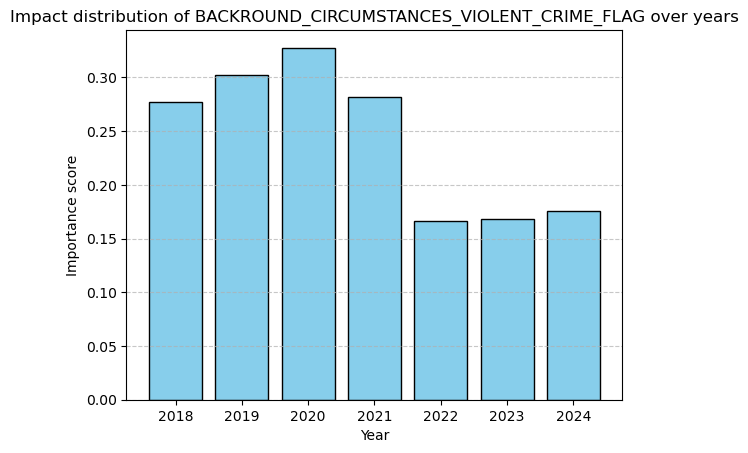

In [47]:
# Compare impact distribution of BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG over year
crime_flag_df = imp_feat_year_level[imp_feat_year_level.Feature=='BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG']

plt.bar(crime_flag_df['year'], crime_flag_df['Importance'], color='skyblue', edgecolor='black')
plt.xlabel('Year')
plt.ylabel('Importance score')
plt.xticks(crime_flag_df['year'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.title('Impact distribution of BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG over years')
plt.show()

**Insight:** *BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG* is most impacted driver from year 2018 to 2021

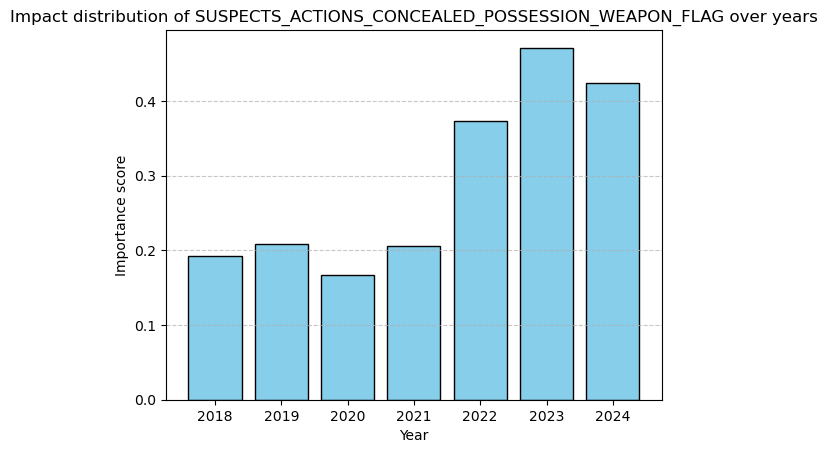

In [41]:
# Compare impact distribution of SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG over year
weapon_flag_df = imp_feat_year_level[imp_feat_year_level.Feature=='SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG']

plt.bar(weapon_flag_df['year'], weapon_flag_df['Importance'], color='skyblue', edgecolor='black')
plt.xlabel('Year')
plt.ylabel('Importance score')
plt.xticks(weapon_flag_df['year'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.title('Impact distribution of SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG over years')
plt.show()

**Insight:** *SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG* is most impacted driver from year 2022 to 2024

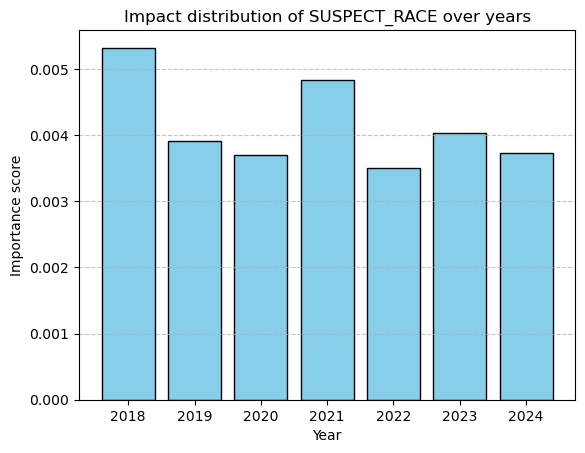

In [36]:
plt.bar(race_imp_feat['year'], race_imp_feat['Importance'], color='skyblue', edgecolor='black')
plt.xlabel('Year')
plt.ylabel('Importance score')
plt.xticks(race_imp_feat['year'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.title('Impact distribution of SUSPECT_RACE over years')
plt.show()

**Insight:** *SUSPECT_RACE* is most impacted driver for year 2018 and 2021

In [52]:
#imp_feat_year_level.to_excel('./output/imp_feat_summary.xlsx',index=False)

In [ ]:
# Feature selection 
# Model fine tune including class weight
# ML model explainability (SHAP Analysis) --> feature interpret 